# Benchmark: Centroid computation

Benchmark comparing Minimum Bounding Rectangle computation across:

* [georust/geo](https://lib.rs/crates/geo) crate
* The [geos C library](https://trac.osgeo.org/geos/), used through high-level Rust bindings via the [geos](https://lib.rs/crates/geos) crate

## Benchmarked operation

Each iteration computes the centroid of the multi-polygon representing all districts of India a 100,000 times.

# Prerequisites

Generate data:

```bash
cd harness
cargo build --release
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/relwithdebinfo" target/release/benchmark_centroid --out-file ../analysis/benchmark_centroid/data.json --geojson-file ../data/india_districts/polbnda_ind.geojson --headlong --iterations 120
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_centroid/data.json
### Statistics: Raw data
                qps            
program         geo        geos
count    110.000000  110.000000
mean      43.296538    0.896711
std        7.249960    0.136855
min        6.421094    0.444483
25%       44.287108    0.934798
50%       44.707892    0.942515
75%       45.715880    0.944883
max       46.052194    0.948411


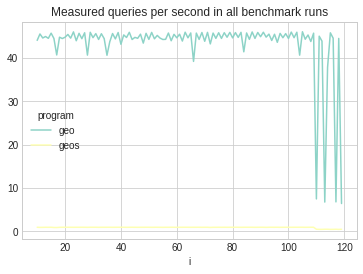

### Statistics: After outlier removal
                qps            
program         geo        geos
count    100.000000  100.000000
mean      44.735234    0.939650
std        1.307605    0.010567
min       39.209820    0.881875
25%       44.318731    0.936705
50%       44.768461    0.943436
75%       45.728941    0.945100
max       46.052194    0.948411


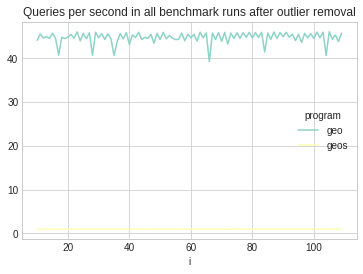

## Ratio of qps compared to geo
                qps
program        geos
count    100.000000
mean       0.021022
std        0.000653
min        0.019980
25%        0.020603
50%        0.020906
75%        0.021229
max        0.024092


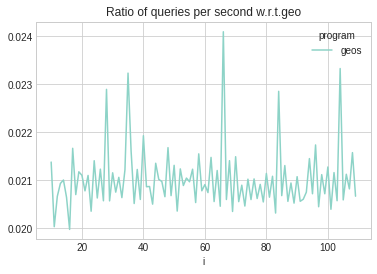

## Ratio of qps compared to geos
                qps
program         geo
count    100.000000
mean      47.611364
std        1.390592
min       41.507048
25%       47.105822
50%       47.832741
75%       48.536409
max       50.049679


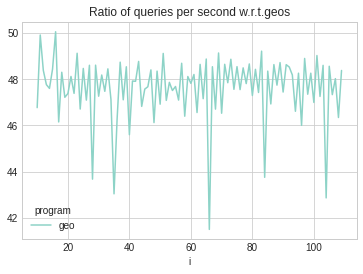

In [4]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data.json')
%run ../common/benchmark_analysis.ipynb
data_series = series_sans_outliers

# Performance benchmarking

To generate the following SVG:

```bash
cd harness
cargo build --release

perf record -F 100 -g --call-graph dwarf -o ../analysis/benchmark_centroid/perf.data -- ./target/release/benchmark_centroid --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 10 --headlong >/dev/null

cd ../analysis/benchmark_centroid
perf script -i perf.data | ../../third_party/stackcollapse-perf.pl > perf.collapsed-stacks.data
../../third_party/flamegraph.pl perf.collapsed-stacks.data > perf.svg
```

![](./perf.svg)

To dig in further, use
```
perf report -i perf.data --call-graph=fractal,0.5
```

# Vectors && sqrt

* most of the overhead in geos is from slower vector indexing operator compared to rust iterators
* A sizable percent is due to sqrt in distance computation -- the algorithm in geo avoids this entirely.

![](./geo_centroid.png)
![](./geos_centroid.png)

# Uber-optimized

When building without debug info, gcc -O3 is used. This makes geos faster.

```bash
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/release" target/release/benchmark_centroid --out-file ../analysis/benchmark_centroid/data-nodbg.json --geojson-file ../data/india_districts/polbnda_ind.geojson --headlong --iterations 120
```

### Loading data from /mnt/data/source/explore-georust/analysis/benchmark_centroid/data-nodbg.json
### Statistics: Raw data
                qps            
program         geo        geos
count    110.000000  110.000000
mean      44.970885    3.830075
std        0.828385    0.104001
min       42.782398    3.263981
25%       44.292141    3.847805
50%       44.827747    3.863928
75%       45.830683    3.875467
max       46.052989    3.898170


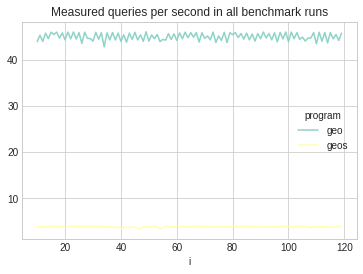

### Statistics: After outlier removal
                qps            
program         geo        geos
count    105.000000  105.000000
mean      45.013963    3.846632
std        0.802936    0.055914
min       43.446379    3.644456
25%       44.308015    3.849981
50%       44.897417    3.863978
75%       45.834518    3.876209
max       46.052989    3.898170


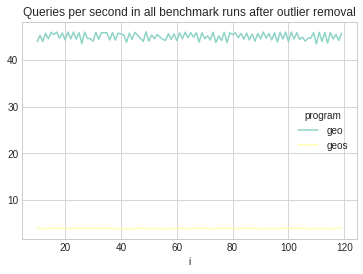

## Ratio of qps compared to geo
                qps
program        geos
count    105.000000
mean       0.085480
std        0.001945
min        0.080160
25%        0.084187
50%        0.085081
75%        0.087058
max        0.089312


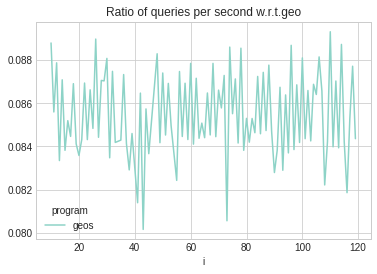

## Ratio of qps compared to geos
                qps
program         geo
count    105.000000
mean      11.704599
std        0.267424
min       11.196658
25%       11.486655
50%       11.753455
75%       11.878373
max       12.475102


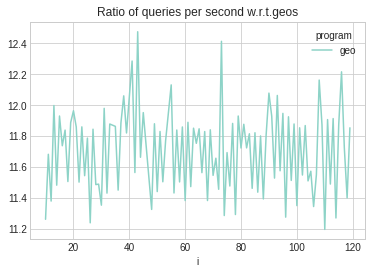

In [5]:
import os
data_absolute_path = os.path.join(os.getcwd(), 'data-nodbg.json')
%run ../common/benchmark_analysis.ipynb

# Uber optimized geos - perf analysis.

Generate with:

```bash
LD_LIBRARY_PATH="${LD_LIBRARY_PATH}:/mnt/data/source/explore-georust/third_party/lib/geos/release" perf record -F 300 -g --call-graph dwarf -o ../analysis/benchmark_centroid/perf-nodbg.data -- ./target/release/benchmark_centroid --geojson-file ../data/india_districts/polbnda_ind.geojson --out-file /dev/null --iterations 10 --headlong >/dev/null
```

Snippet from

```bash
perf report -i perf-nodbg.data --call-graph=fractal,0.5
```

![](./geos_area_still_iteration.png)

Qualitatively unchanged. Less symbols, but largest time is still taken by the same iteration path

# Root cause

Algorithmic differences + optimization opportunities.

Histograsm (one for geo generated with `threshold=0.1`):

<pre>
-   88.45%     0.00%  benchmark_centr  benchmark_centroid  [.] benchmark_centroid::geos_centroid
   - benchmark_centroid::geos_centroid
      - 88.28% <geos::geometry::Geometry as geos::geometry::Geom>::get_centroid
           GEOSGetCentroid_r
         - execute<GEOSGetCentroid_r::{lambda()#1}, (decltype(nullptr))0>
            - GEOSGetCentroid_r::{lambda()#1}::operator()
               - 88.10% geos::geom::Geometry::getCentroid
                  - 87.93% geos::geom::Geometry::getCentroid
                     - 87.66% geos::algorithm::Centroid::getCentroid
                        - 87.49% geos::algorithm::Centroid::Centroid
                           - 87.40% geos::algorithm::Centroid::add
                              - 87.23% geos::algorithm::Centroid::add
                                 - 87.05% geos::algorithm::Centroid::add
                                    - 86.88% geos::algorithm::Centroid::addShell
                                       - 41.91% geos::algorithm::Centroid::addLineSegments
                                          - 15.66% geos::geom::CoordinateSequence::operator[]
                                             - geos::geom::CoordinateArraySequence::getAt
                                                  4.72% std::vector<geos::geom::Coordinate, std::allocator<geos::geom::Coordinate> >::operator[]
                                                  1.31% std::vector<geos::geom::Coordinate, std::allocator<geos::geom::Coordinate> >::operator[]@plt
                                          - 11.72% geos::geom::Coordinate::distance
                                               2.89% __ieee754_sqrt (inlined)
                                               1.49% __sqrt
                                            0.61% geos::geom::CoordinateSequence::operator[]@plt
                                       - 15.66% geos::algorithm::Centroid::addTriangle
                                            5.07% geos::algorithm::Centroid::centroid3
                                            2.54% geos::algorithm::Centroid::area2
                                       - 13.91% geos::algorithm::Orientation::isCCW
                                          - 5.25% geos::geom::CoordinateSequence::getY
                                             - geos::geom::CoordinateSequence::getOrdinate
                                                - geos::geom::CoordinateArraySequence::getAt
                                                     std::vector<geos::geom::Coordinate, std::allocator<geos::geom::Coordinate> >::operator[]
                                          - 0.96% geos::geom::CoordinateArraySequence::getAt
                                               std::vector<geos::geom::Coordinate, std::allocator<geos::geom::Coordinate> >::operator[]
                                       - 7.26% std::unique_ptr<geos::geom::Coordinate, std::default_delete<geos::geom::Coordinate> >::operator*
                                          - 5.69% std::unique_ptr<geos::geom::Coordinate, std::default_delete<geos::geom::Coordinate> >::get
                                             - 4.90% std::__uniq_ptr_impl<geos::geom::Coordinate, std::default_delete<geos::geom::Coordinate> >::_M_ptr
                                                - std::get<0ul, geos::geom::Coordinate*, std::default_delete<geos::geom::Coordinate> >
                                                   - std::__get_helper<0ul, geos::geom::Coordinate*, std::default_delete<geos::geom::Coordinate> >
                                                        1.84% std::_Tuple_impl<0ul, geos::geom::Coordinate*, std::default_delete<geos::geom::Coordinate> >::_M_head
                                       - 5.42% geos::geom::CoordinateSequence::operator[]
                                          - geos::geom::CoordinateArraySequence::getAt
                                               1.31% std::vector<geos::geom::Coordinate, std::allocator<geos::geom::Coordinate> >::operator[]

</pre>

<pre>
-    1.92%     0.00%  benchmark_centr  benchmark_centroid  [.] benchmark_centroid::geo_centroid
     benchmark_centroid::geo_centroid
     <geo_types::multi_polygon::MultiPolygon<T> as geo::algorithm::centroid::Centroid>::centroid (inlined)
     geo::algorithm::centroid::CentroidOperation<T>::add_multi_polygon
     geo::algorithm::centroid::CentroidOperation<T>::add_polygon (inlined)
   - geo::algorithm::centroid::CentroidOperation<T>::add_ring
      - 1.05% <core::iter::adapters::map::Map<I,F> as core::iter::traits::iterator::Iterator>::fold (inlined)
         - core::iter::traits::iterator::Iterator::fold (inlined)
            - 0.61% core::iter::adapters::map::map_fold::_$u7b$$u7b$closure$u7d$$u7d$::h852ff4143359a141 (inlined)
               - 0.44% geo::algorithm::centroid::CentroidOperation$LT$T$GT$::add_ring::_$u7b$$u7b$closure$u7d$$u7d$::hba507e9435c4b508 (inlined)
                  - 0.17% <geo_types::coordinate::Coordinate<T> as core::ops::arith::Mul<T>>::mul (inlined)
                       <f64 as core::ops::arith::Mul>::mul (inlined)
                  - 0.17% <geo_types::coordinate::Coordinate<T> as core::ops::arith::Add>::add (inlined)
                       <f64 as core::ops::arith::Add>::add (inlined)
                 0.17% geo_types::line_string::LineString$LT$T$GT$::lines::_$u7b$$u7b$closure$u7d$$u7d$::ha94da3e3994f7f24 (inlined)
              0.44% <core::slice::iter::Windows<T> as core::iter::traits::iterator::Iterator>::next (inlined)
      - 0.87% geo::algorithm::area::get_linestring_area
         - geo::algorithm::area::twice_signed_ring_area (inlined)
            - 0.61% <core::iter::adapters::map::Map<I,F> as core::iter::traits::iterator::Iterator>::next (inlined)
               - 0.35% core::option::Option<T>::map (inlined)
                    core::ops::function::impls::<impl core::ops::function::FnOnce<A> for &mut F>::call_once (inlined)
                    geo_types::line_string::LineString$LT$T$GT$::lines::_$u7b$$u7b$closure$u7d$$u7d$::ha94da3e3994f7f24 (inlined)
                 0.26% <core::slice::iter::Windows<T> as core::iter::traits::iterator::Iterator>::next (inlined)
            - 0.17% <geo_types::line::Line<T> as geo::algorithm::map_coords::MapCoords<T,NT>>::map_coords (inlined)
                 <geo_types::point::Point<T> as geo::algorithm::map_coords::MapCoords<T,NT>>::map_coords (inlined)
                 geo::algorithm::area::twice_signed_ring_area::_$u7b$$u7b$closure$u7d$$u7d$::h0c0bb9bdc36e4a85 (inlined)
                 <f64 as core::ops::arith::Sub>::sub (inlined)

</pre>

* Simple algorithm leads to highly inlined machine code for geo.
* Wildly different algorithms: geo computes area only. geos computes area, distance (including a costly sqrt operation), clockwise/anti-clockwise ring winding...
  * A lot more numerical operations. geos::algorithm::Centroid::addTriangle (15.66%), geos::algorithm::Orientation::isCCW (13.91%),  geos::geom::Coordinate::distance (11.72%).
  * Array indexing accounts for a larger part of geos time. Because of more complex algorithm, more indexing than [geo](./index-operator-callee.hist), and also indexing
  has more complex machine code than Rust iterators. Accounts for ~23% of total runtime.

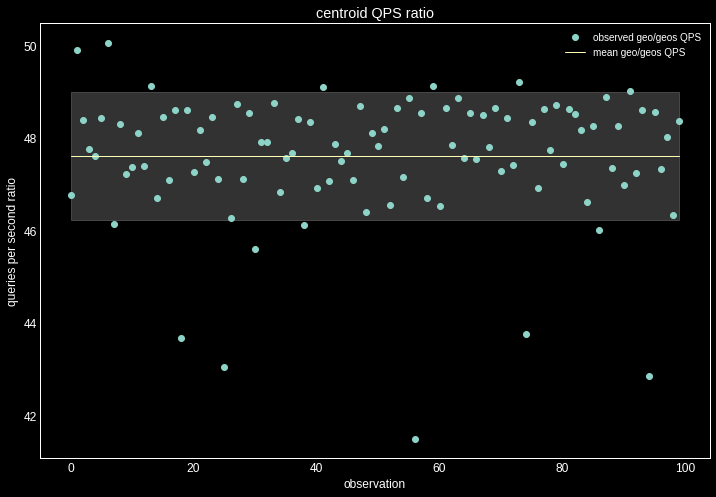

In [6]:
series_geo = data_series.iloc[:, 0]
assert series_geo.name == ('qps', 'geo')
series_geos = data_series.iloc[:, 1]
assert series_geos.name == ('qps', 'geos')

ratio = series_geo.divide(series_geos)

plt.style.use('dark_background')

@plt.rc_context({
    'figure.figsize': (12, 8),
    'font.size': 12,
    'image.cmap': plt.get_cmap('Pastel1'),
})
def initialize_plot():
    fig = plt.figure()
    return fig.add_subplot(title='centroid QPS ratio')

x = range(ratio.size)
ax = initialize_plot()
ax.plot(x, ratio, linewidth=0, marker='o', label='observed geo/geos QPS')
ax.plot(x, [ratio.mean()] * ratio.size, linewidth=1, label='mean geo/geos QPS')
ax.fill_between(x, ratio.mean() - ratio.std(), ratio.mean() + ratio.std(), alpha=0.2, color='white')
ax.legend()
ax.set_xlabel('observation')
ax.set_ylabel('queries per second ratio')
ax.grid(False)
plt.savefig('centroid_qps_ratio.svg', transparent=True)